In [84]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat
from utils.plotting_utils import topography_map
from scipy.signal import butter, filtfilt, resample
from snn.resonator import create_excitatory_inhibitory_resonator

from utils import copy_filter_hp_to_other_clock_frequency

EEG_FOLDER = f'../datasets/EEG_data_for_Mental_Attention_State_Detection'

trial = 4
channel = 'F4'

fs = 128

bands = {
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 32),
    'gamma': (32, 60),
}

data_root = f'{EEG_FOLDER}/EEG_Data'

# Channels
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

# Util Methods

In [45]:
from scipy.stats import zscore

# number of samples in the original and resampled signals
def resample_signal(f_new, f_source, data):
    n_samples_orig = data.shape[0]
    n_samples_new = int(n_samples_orig * f_new / f_source)

    # resample the signal
    return resample(data, n_samples_new)

def bp_filter(data, f_lo, f_hi, fs):
    """ Digital band pass filter (6-th order Butterworth)
    Args:
        data: numpy.array, time along axis 0
        (f_lo, f_hi): frequency band to extract [Hz]
        fs: sampling frequency [Hz]
    Returns:
        data_filt: band-pass filtered data, same shape as data """
    data_filt = np.zeros_like(data)
    f_ny = fs / 2.  # Nyquist frequency
    b_lo = f_lo / f_ny  # normalized frequency [0..1]
    b_hi = f_hi / f_ny  # normalized frequency [0..1]
    # band-pass filter parameters
    p_lp = {"N":6, "Wn":b_hi, "btype":"lowpass", "analog":False, "output":"ba"}
    p_hp = {"N":6, "Wn":b_lo, "btype":"highpass", "analog":False, "output":"ba"}
    bp_b1, bp_a1 = butter(**p_lp)
    bp_b2, bp_a2 = butter(**p_hp)
    data_filt = filtfilt(bp_b1, bp_a1, data, axis=0)
    data_filt = filtfilt(bp_b2, bp_a2, data_filt, axis=0)
    return data_filt


#  Function to read in the EEG data and extract the valid lead data, low and high pass filter and z-transform the data.
#  Returns a dataframe.
def get_EEG_data(data_root, filename):
    # Extract the data from one of these files.
    hz = fs
    #filename = 'eeg_record30.mat'
    mat = loadmat(f'{data_root}/{filename}')
    data = pd.DataFrame.from_dict(mat["o"]["data"][0,0])

    # Limit the data to the 7 valid EEG leads.
    dat = data.filter(list(range(3, 17)))
    dat.columns = list(range(1, 15))
    dat = dat.filter([1,2, 3, 4,5,6, 7, 8, 9,10,11,12,13,14,17], axis=1)
    labels = ['AF3','F7', 'F3','FC5','T7','P7','O1', 'O2','P8','T8', 'FC6','F4','F8','AF4']  # FP2 should really be AF4
    dat.columns = labels

    # Filter the data, high pass 2 Hz, low pass 40 Hz.
    lo, hi = .5, 62
    # Do the filtering.
    datf = bp_filter(dat.to_numpy(), lo, hi, hz)

    # Convert back to a dataframe.
    dat = pd.DataFrame({c: datf[:, i] for i, c in enumerate(labels)})

    # Z-transform each column
    dat = dat.apply(zscore)

    return dat

def get_trial_data(trial):
    dat = get_EEG_data(data_root, f'eeg_record{trial}.mat')
    return dat


def plot_spectrogram(data, channel_name, fs, fmin, fmax, show=True):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    Sxx, freqs, bins, im = plt.specgram(data, NFFT=2*fs, Fs=fs,
                                         noverlap=fs, cmap='jet')
    # plt.vlines([600, 1200], ymin=fmin, ymax=fmax, colors='black')
    if show:
        plt.ylim(fmin, fmax)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title(f'ch={channel_name} fs={fs} band=({fmin} - {fmax})Hz')
        plt.imshow(Sxx, aspect='auto',
                   cmap='jet', origin='lower',
                   extent=[bins[0], bins[-1], freqs[0], freqs[-1]],
                   vmin=0, vmax=np.max(Sxx[(freqs >= fmin) & (freqs <= fmax)]))
        plt.colorbar()
    else:
        plt.close()
    return Sxx


def fft_spectogram2bins(Sxx, window):
    bins_count = len(Sxx[0])//window + 1
    bin_sxx = np.zeros((4, bins_count))

    # dict to array
    for ch_i, (f_min, f_max) in enumerate(bands.values()):
        for i in range(bins_count):
            bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:(i+1)*window]) / (f_max - f_min)
        bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:]) / (f_max - f_min)

    return bin_sxx

def plot_bins(Sxx, duration, labels, annotate=True, rotate_annotate=False, show=True):
    fig, ax = plt.subplots(figsize=(14, 5))
    im = ax.imshow(Sxx, aspect='auto',
               cmap='jet', origin='lower',
               extent=[0, duration, 0, len(Sxx)]
               )

    ax.set_yticks(np.arange(len(Sxx)), labels=labels)
    if annotate:
        bin_size = duration / len(Sxx[0])
        rotation_degree = 90 * rotate_annotate
        for i in range(len(Sxx)):
            for j in range(len(Sxx[i])):
                text = ax.text(j * bin_size + bin_size*.5, i + .5,  f'{Sxx[i, j]:.4f}',
                               rotation=rotation_degree,
                               ha="center", va="center", color="white")

    fig.tight_layout()
    fig.colorbar(im, ax=ax)
    if show:
        plt.show()


def array_to_bins(array, N):
    bins = np.array_split(array, N)
    bin_sums = np.array([np.sum(bin) for bin in bins], dtype=np.int64)
    return bin_sums


def spikes_to_bands(spikes_spectrogram):
    bands_spectrogram = np.zeros((4, spikes_spectrogram.shape[1]))
    bands_spectrogram[0] = np.sum(spikes_spectrogram[:5], axis=0) / 768
    bands_spectrogram[1] = np.sum(spikes_spectrogram[5:10], axis=0) / 1536
    bands_spectrogram[2] = np.sum(spikes_spectrogram[10:15], axis=0) / 3072
    bands_spectrogram[3] = np.sum(spikes_spectrogram[15:20], axis=0) / 6144
    return bands_spectrogram


def spikes_event_spectrogram(clk_freq, events, window_ms):
    window = int(clk_freq/1000 * window_ms)
    N = events[-1] // window + 1
    bins = np.zeros(N, dtype=int)
    unique_indices, counts = np.unique(np.array(events) // window, return_counts=True)
    bins[unique_indices] = counts
    return bins


## Choose a signal, visualize in time and frequency domain.

In [46]:
example_data = get_trial_data(trial)

### FFT Plot on all of the signal
Plot a fft spectrogram and in bins to be able to see more accuratly where is most of the activation.

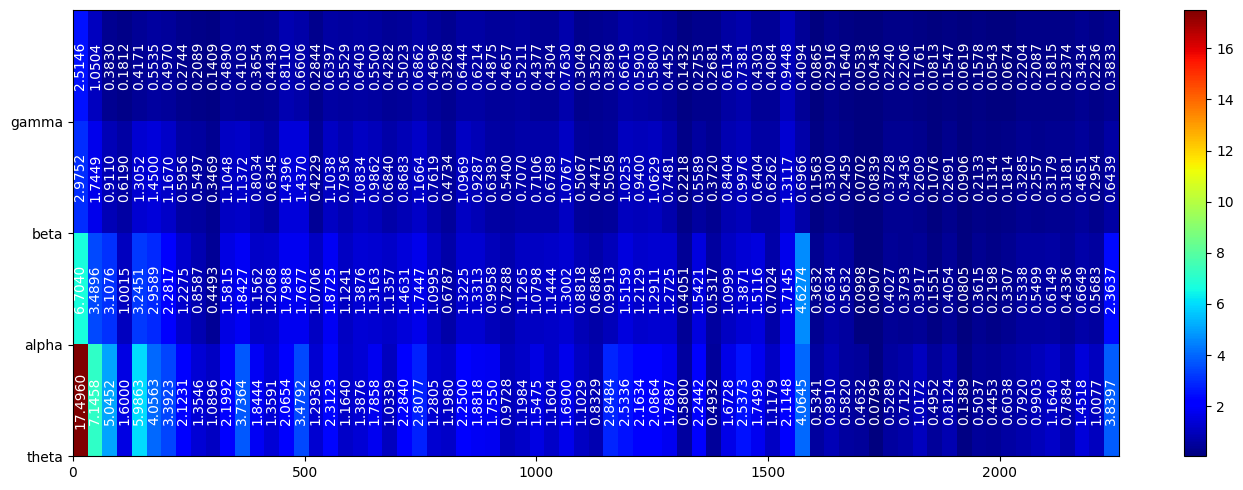

In [47]:
fft_spectogram = plot_spectrogram(example_data[channel], channel_name=channel, fs=fs, fmin=2, fmax=40, show=False)
fft_bin_spectogram = fft_spectogram2bins(fft_spectogram, 32)
plot_bins(fft_bin_spectogram, len(example_data[channel])/fs, bands.keys(), annotate=True, rotate_annotate=True)

### Choose a slice from the signal for faster study

In [50]:
time_start_s = 1670
time_end_s = 1715
sliced_data = example_data[channel][time_start_s*fs:time_end_s*fs]

Text(0.5, 1.0, 'Slice data on Time domain')

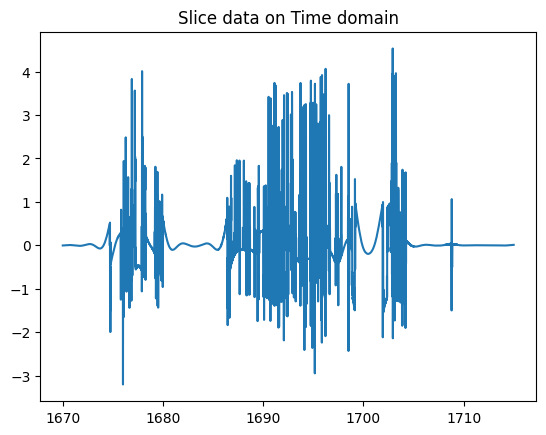

In [49]:
plt.plot(np.linspace(time_start_s, time_end_s, len(sliced_data)) , sliced_data)
plt.title('Slice data on Time domain')

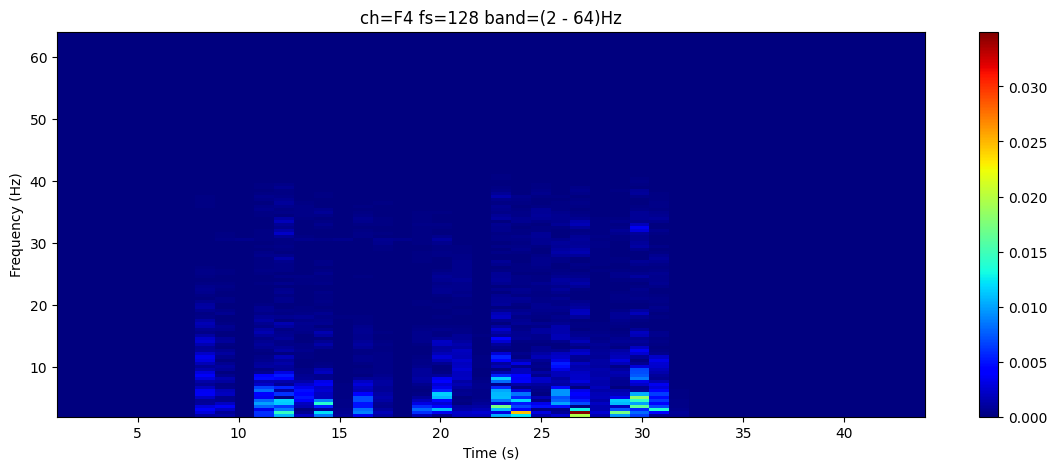

Text(0.5, 1.0, 'FFT sum amplitude in 1s')

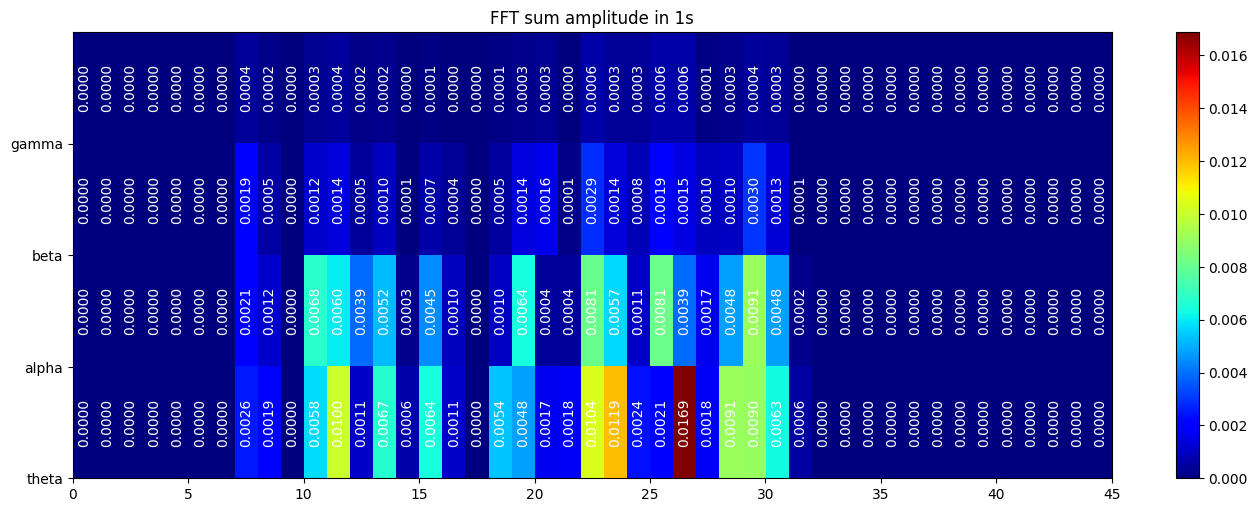

In [97]:
sliced_data = example_data[channel][1670*fs:1715*fs]

fft_spectogram = plot_spectrogram(sliced_data, channel_name=channel, fs=fs, fmin=2, fmax=64, show=True)
fft_bin_spectogram = fft_spectogram2bins(fft_spectogram, 1)
plot_bins(fft_bin_spectogram, len(sliced_data)/fs, bands.keys(), rotate_annotate=True, show=False)
plt.title('FFT sum amplitude in 1s')


### Spikes Visualization

Normalize the data first!

In [58]:
sliced_data /= np.max(np.abs(sliced_data))

In [60]:
# Chosen frequencies / resonators
# theta 76800 - [4.000, 4.500, 5.000, 5.900, 6.950]
# alpha 153600 - [8.000, 9.000, 10.000, 11.800, 13.900]
# beta 307200 - ['16.000', '18.000', '20.000', '23.600', '27.800']
# gamma 614400 - ['32.000', '36.000', '40.000', '47.200', '55.600']

# copy_filter_hp_to_other_clock_frequency(1536000, 76800)
# copy_filter_hp_to_other_clock_frequency(1536000, 153600)
# copy_filter_hp_to_other_clock_frequency(1536000, 307200)
# copy_filter_hp_to_other_clock_frequency(1536000, 614400)


clk_resonators = {
    76800: ['4.000', '4.500', '5.000', '5.900', '6.950'],
    153600: ['8.000', '9.000', '10.000', '11.800', '13.900'],
    307200: ['16.000', '18.000', '20.000', '23.600', '27.800'],
    614400: ['32.000', '36.000', '40.000', '47.200', '55.600'],
}

### Generate spikes for the resonators.

In [61]:
from tqdm import tqdm

output = {}
with tqdm(total=20) as pbar:
    for clk_i, (clk_freq, list_of_f0) in enumerate(clk_resonators.items()):
        sliced_data_resampled = resample_signal(clk_freq, fs, sliced_data)
        output[clk_freq] = []
        for f_i, f0 in enumerate(list_of_f0):
            resonator = create_excitatory_inhibitory_resonator(
                freq0=f0,
                clk_freq=clk_freq)
            resonator.log_out_spikes(-1)
            output_neuron = resonator.layers_neurons[-1].neurons[-1]
            # append 5 seconds of zero to make the resonator converge.
            resonator.input_full_data(np.zeros(clk_freq * 5))
            output_neuron.forget_logs()
            resonator.input_full_data(sliced_data_resampled)
            # extract the spikes without the appended zeros
            output[clk_freq].append(output_neuron.out_spikes())
            pbar.update(1)

with open('sliced_data_output.pickle', 'wb') as f:
    pickle.dump(output, f, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 20/20 [17:11<00:00, 51.58s/it]


In [5]:
import pickle

with open('sliced_data_output.pickle', 'rb') as f:
    output = pickle.load(f)

### 1 Resonator

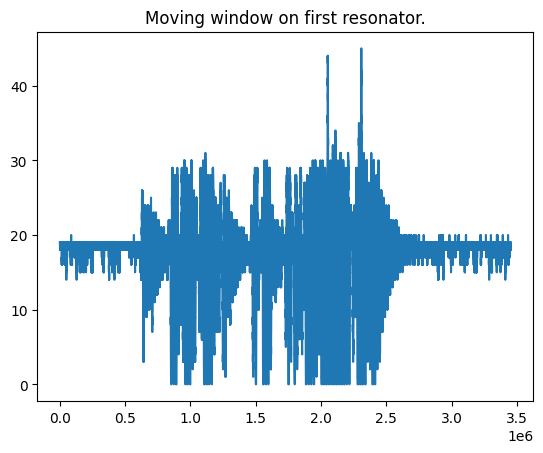

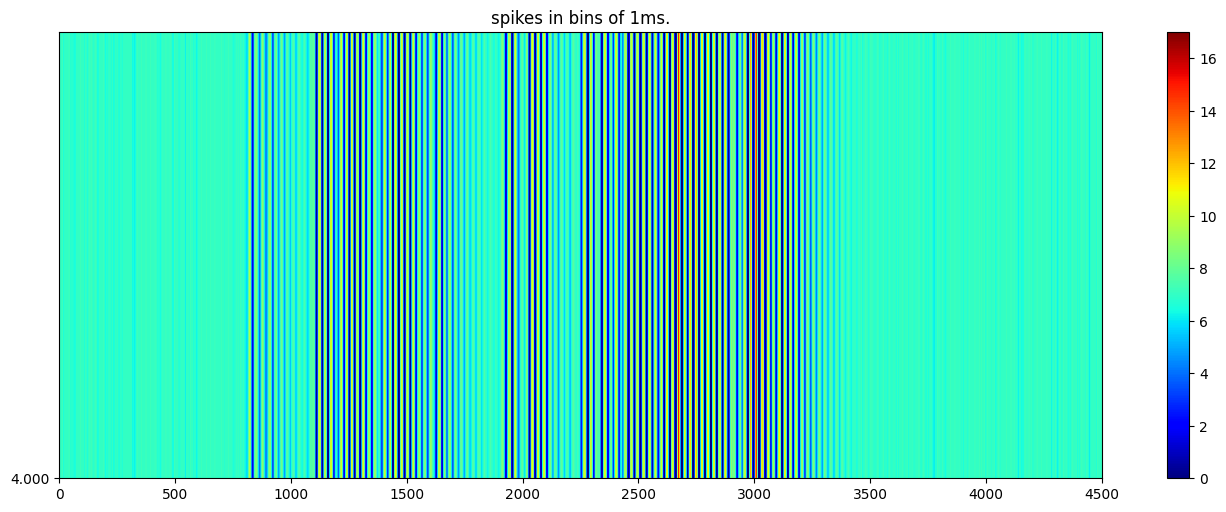

In [272]:
clk_freq = next(iter(output.keys()))

y_spikes = output[clk_freq][0]
y_spikes = np.convolve(y_spikes, np.ones(2000, dtype=int), 'valid')
plt.plot(y_spikes)
plt.title('Moving window on first resonator.')
plt.show()

y_spikes = output[clk_freq][0]
spikes_spectrogram = np.zeros((1, len(y_spikes)//clk_freq*100))
spikes_spectrogram[0] = array_to_bins(y_spikes, spikes_spectrogram.shape[1])
plot_bins(spikes_spectrogram, spikes_spectrogram.shape[1], labels=['4.000'], annotate=False, show=False)
plt.title('spikes in bins of 1ms.')
plt.show()

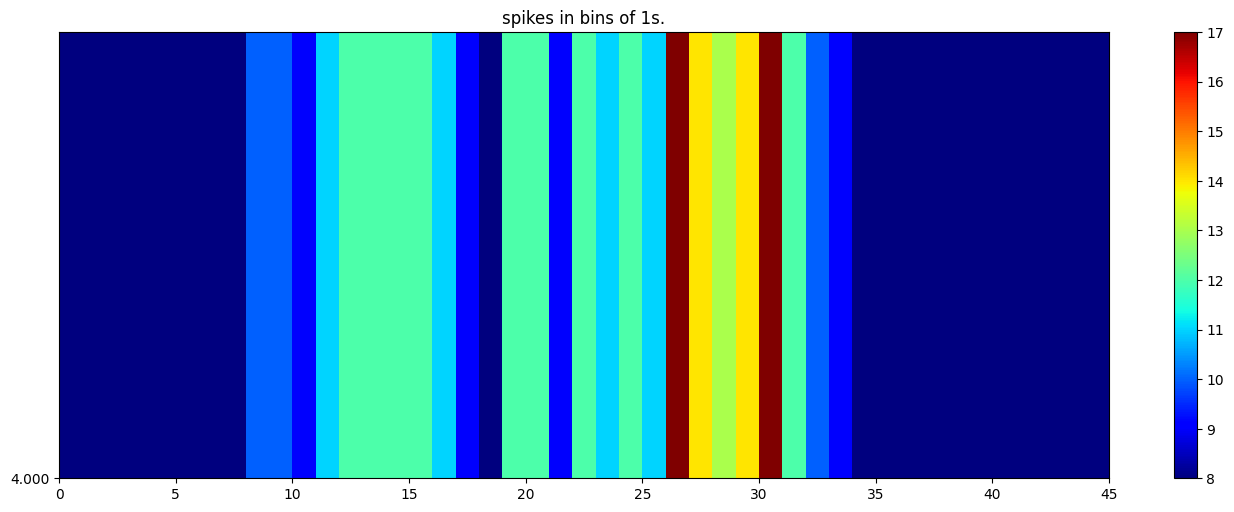

In [78]:
clk_freq = 76800
duration = 45

events = output[clk_freq][0]
spikes_spectrogram = np.zeros((1, (duration * 1000)// 10))
max_spikes_spectrogram = np.zeros((1, (duration * 1000) // 1000))
spikes_spectrogram[0] = spikes_event_spectrogram(clk_freq, events, 10)
max_spikes_spectrogram[0] = spikes_spectrogram[0].reshape(-1, len(spikes_spectrogram[0])//len(max_spikes_spectrogram[0])).max(axis=1)

plot_bins(max_spikes_spectrogram, max_spikes_spectrogram.shape[1], labels=['4.000'], annotate=False, show=False, rotate_annotate=True)
plt.title('spikes in bins of 1s.')
plt.show()

### All the resonators

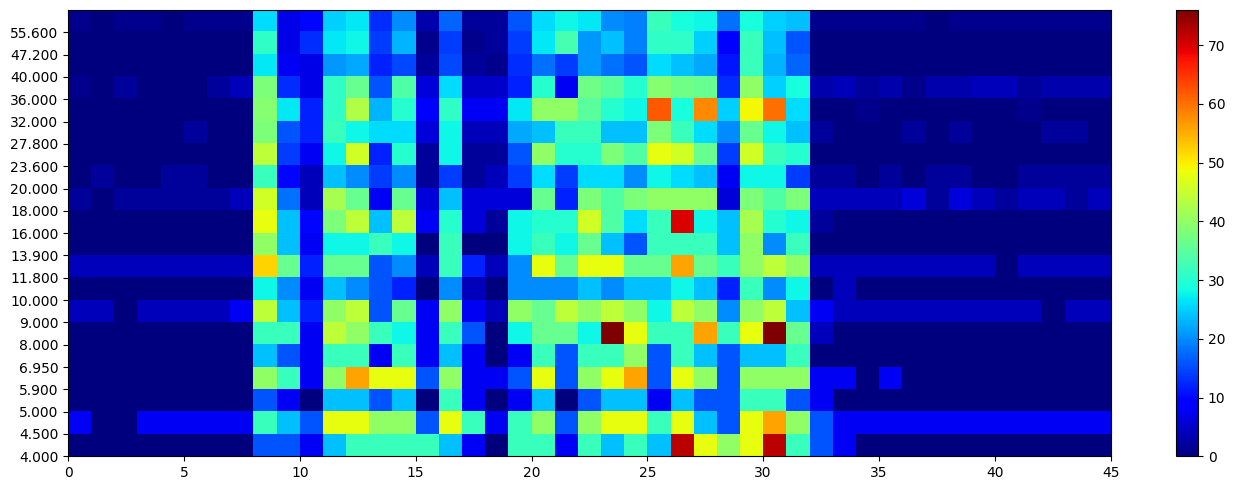

In [88]:
spikes_array = sum(output.values(), start=[])
clk_freq, values = next(iter(output.items()))

max_spikes_spectrogram = np.zeros((len(spikes_array), (duration * 1000) // 1000))

# axis 0 - resonators
# axis 1 - number of bins ( I set to 1ms)
main_clk = np.lcm.reduce(list(output.keys()))
i = 0
for clk_freq, spikes_arrays in output.items():
    for events in spikes_arrays:
        # spikes_spectrogram[i] = array_to_bins(spikes, spikes_spectrogram.shape[1])
        spikes_spectrogram = spikes_event_spectrogram(clk_freq, events, 10)
        max_spikes_spectrogram[i] = spikes_spectrogram.reshape(-1, len(spikes_spectrogram)//len(max_spikes_spectrogram[i])).max(axis=1)
        max_spikes_spectrogram[i] -= np.min(max_spikes_spectrogram[i])
        max_spikes_spectrogram[i] *= (main_clk / clk_freq)
        i += 1

plot_bins(max_spikes_spectrogram, max_spikes_spectrogram.shape[1], labels=sum(clk_resonators.values(), []), annotate=False)

Text(0.5, 1.0, 'Spikes ratio in 1 second')

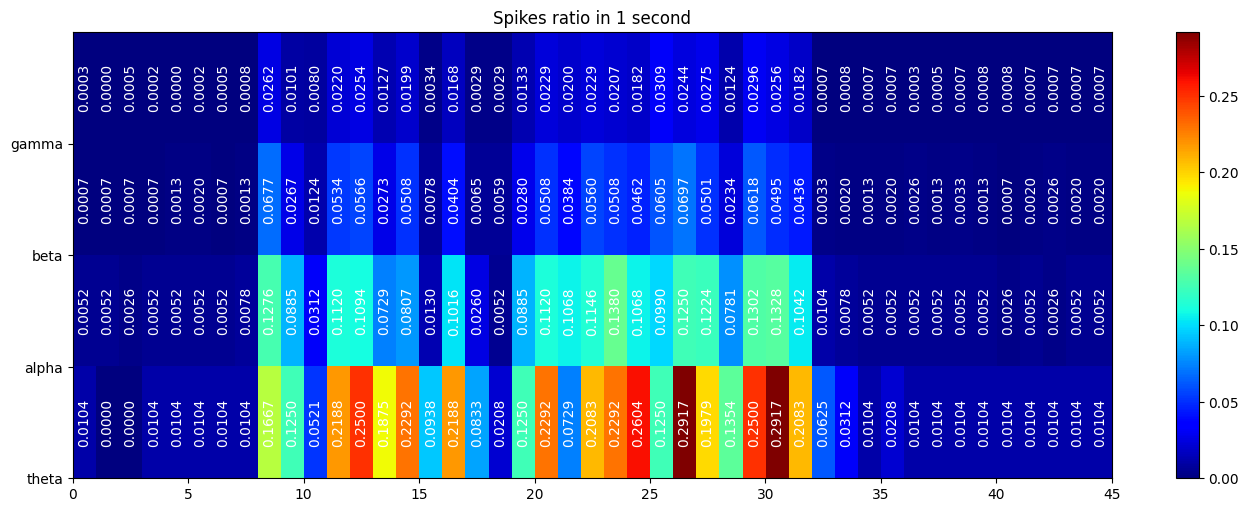

In [96]:
spikes_bands_spectrogram = spikes_to_bands(max_spikes_spectrogram)
plot_bins(spikes_bands_spectrogram, len(sliced_data)/fs, labels=bands.keys(), annotate=True, rotate_annotate=True, show=False)
plt.title('Spikes ratio in 1 second')

### Load Preprocessed Spikes Data.

In [3]:
import numpy as np

# Create a sample NumPy array
arr = np.array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1])
# Use numpy.where() to get the indices of all the 1s
indices = np.where(arr == 1)[0]

# Print the indices
print(indices)

[ 1  3  4  6 10 11]


In [41]:
from pathlib import Path


class ResonatorSpikes:

    def __init__(self, clk_freq, resonator_freq, spikes_path):
        self.clk_freq = clk_freq
        self.resonator_freq = resonator_freq
        self.events = None
        self._load_spikes(spikes_path)

    def _load_spikes(self, spikes_path):
        spikes_array = np.load(spikes_path)['spikes']
        # if the file is already events based spikes
        if np.max(spikes_array) > 1:
            self.events = spikes_array
        else:
            self.events = np.where(spikes_array == 1)[0]

    def spectrogram(self, window_ms):
        window = int(self.clk_freq/1000 * window_ms)
        N = self.events[-1] // window + 1
        bins = np.zeros(N, dtype=int)
        unique_indices, counts = np.unique(np.array(self.events) // window, return_counts=True)
        bins[unique_indices] = counts
        return bins



class ChannelSpikes:

    def __init__(self, base_folder, channel_name):
        self.channel_name = channel_name
        self.resonators_output = {}
        self._load_resonators_output(base_folder)

    def _load_resonators_output(self, base_folder):
        channel_folder = base_folder / self.channel_name
        for clk_freq in os.listdir(channel_folder):
            clk_folder = channel_folder / clk_freq
            for spikes in os.listdir(clk_folder):
                resonator_freq = spikes[:-4]
                self.resonators_output[resonator_freq] = ResonatorSpikes(int(clk_freq), float(resonator_freq), f'{clk_folder}/{spikes}')

class SignalSpikes:

    def __init__(self, signal_folder, label):
        self.label = label
        self.channels = {
            channel: ChannelSpikes(signal_folder, channel)
            for channel in os.listdir(signal_folder)
        }


class Trial:

    def __init__(self, base_folder, trial):
        self.trial = trial
        self.base_folder = Path(f'{base_folder}/{trial}')

    def load(self, minute):
        # make sure it's in string format.
        minute = str(minute)
        for label in os.listdir(self.base_folder):
            for m in os.listdir(self.base_folder / label):
                if m == minute:
                    return SignalSpikes(self.base_folder / label / m, label=label)

In [46]:
trial = Trial(f'../datasets/EEG_data_for_Mental_Attention_State_Detection/EEG_spikes_clk/', 3)
signal_spikes5 = trial.load(5)
signal_spikes6 = trial.load(6)

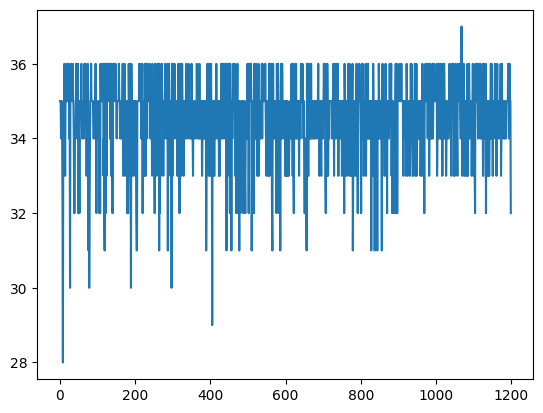

In [50]:
sig_spectrogram = signal_spikes5.channels['AF3'].resonators_output['4.000'].spectrogram(50)
plt.plot(sig_spectrogram)

## Topograph Map

In [197]:
fs = 128

class Subject:

    def __init__(self, number, slice_from, slice_to, sample_length=10):
        self.number = number
        # records = np.arange(1, 7) + (number * 7)
        trials = np.arange(3, 7) + (number * 7)
        samples = np.arange(0, slice_to - slice_from, sample_length)
        self.focus_label = Label('focus', samples, trials, slice_from, slice_to, sample_length)
        self.unfocus_label = Label('unfocus', samples, trials, slice_from + 600, slice_to + 600, sample_length)
        self.drowsed_label = Label('drowsed', samples, trials, slice_from + 1200, slice_to + 1200, sample_length)


class Label:

    def __init__(self, label, samples, trials, slice_from, slice_to, sample_length):
        self.label = label
        self.slice_to = slice_to
        self.slice_from = slice_from
        self.sample_length = sample_length

        topographic = {ch: np.zeros((len(samples) * len(trials), fs + 1, sample_length))
                       for ch in channels}
        time_signals = {ch: np.zeros((len(samples) * len(trials), fs * sample_length))
                       for ch in channels}
        for i, trial in enumerate(trials):
            trial_data = get_trial_data(trial)
            for ch in trial_data.columns:
                fft_spectogram = plot_spectrogram(trial_data[ch][slice_from * fs:slice_to * fs], channel_name=ch, fs=fs, fmin=0, fmax=63, show=False)
                for j, sample in enumerate(samples):
                    # fft_spectogram.shape[1] is 129, probably not divided by sample length.
                    actual_sample_length = fft_spectogram[:, sample:sample+sample_length].shape[1]
                    topographic[ch][i * len(samples) + j, :, :actual_sample_length] = fft_spectogram[:, sample:sample+sample_length]

                    # time domain signal
                    time_signals[ch][i * len(samples) + j, :] = trial_data[ch][(slice_from + sample) * fs:(slice_from + sample+sample_length) * fs]

        self.topographic = topographic
        self.time_signals = time_signals

slice_from = 120
slice_to = 130
subject0 = Subject(0, slice_from, slice_to)

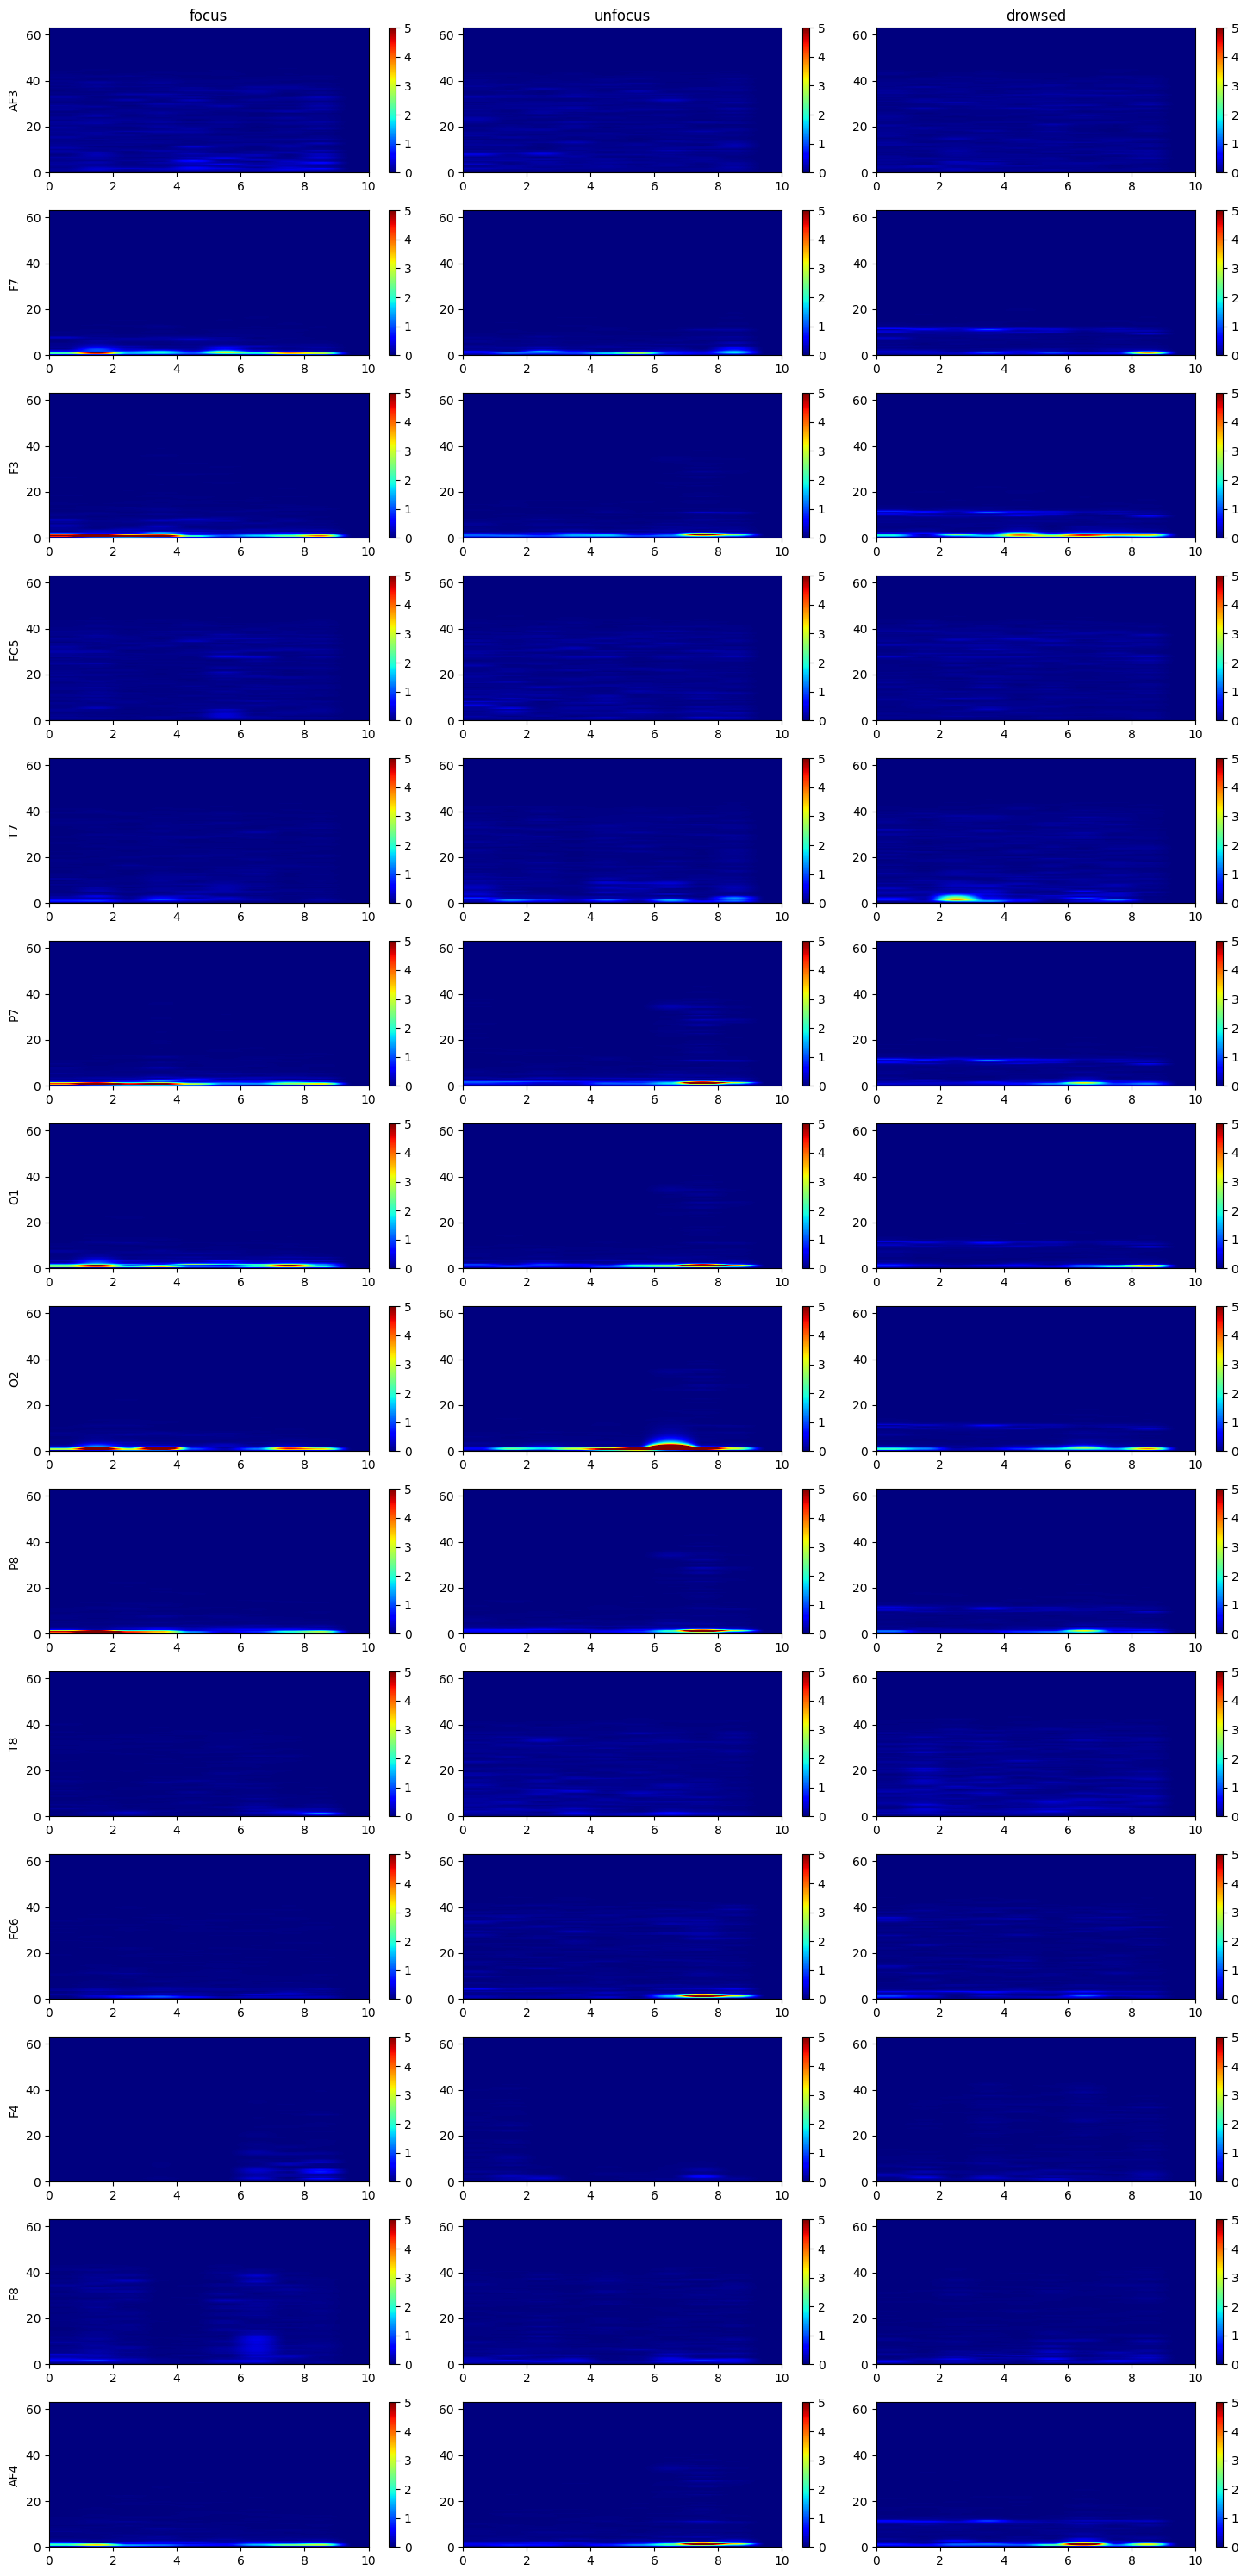

In [198]:
# Create the figure and axes
fig, axs = plt.subplots(14, 3, figsize=(15, 30))

# Iterate through the subplots
labels = [subject0.focus_label, subject0.unfocus_label, subject0.drowsed_label]
fmin, fmax = 0, 63
for j, label_inst in enumerate(labels):
    axs[0, j].title.set_text(label_inst.label)
    for i, (ch, top) in enumerate(label_inst.topographic.items()):
        ax = axs[i, j]
        im = ax.imshow(
            top.sum(axis=0), aspect='auto',
            cmap='jet', origin='lower',
            extent=[0, label_inst.sample_length, fmin, fmax],
            vmin=0, vmax=5
        )

        cbar = fig.colorbar(im, ax=ax)
        axs[i, 0].set_ylabel(ch)


# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Check Active Channels

In [214]:
# Iterate through the subplots
def create_df_features(subject):

    labels = [subject.focus_label, subject.unfocus_label, subject.drowsed_label]

    df_mean_data = {
        f'{inst_label.label}_{ch}': []
        for inst_label in labels
        for ch in inst_label.time_signals.keys()
    }

    df_max_data = {
        f'{inst_label.label}_{ch}': []
        for inst_label in labels
        for ch in inst_label.time_signals.keys()
    }

    df_std_data = {
        f'{inst_label.label}_{ch}': []
        for inst_label in labels
        for ch in inst_label.time_signals.keys()
    }

    for j, label_inst in enumerate(labels):
        axs[0, j].title.set_text(label_inst.label)
        for i, (ch, sig) in enumerate(label_inst.time_signals.items()):
            for sample in sig:
                df_mean_data[f'{label_inst.label}_{ch}'].append(np.mean(sample))
                df_max_data[f'{label_inst.label}_{ch}'].append(np.max(sample))
                df_std_data[f'{label_inst.label}_{ch}'].append(np.std(sample))

    df_mean = pd.DataFrame(df_mean_data)
    df_max = pd.DataFrame(df_max_data)
    df_std = pd.DataFrame(df_std_data)

    return df_mean, df_max, df_std


def create_ch_feature(subject, label, feature):
    feature_id = {
        'mean': 0,
        'max': 1,
        'std': 2
    }[feature]
    df = create_df_features(subject)[feature_id]
    selected_columns = df.columns[df.columns.str.startswith(label)]
    df = df[selected_columns]
    ch_columns = np.array(list(df.columns.str.split('_').values))[:, 1]
    df.columns = ch_columns
    return df

def check_ch_activation(subject, label, feature, threshold):
    df = create_ch_feature(subject, label, feature)
    df = df > threshold

    row_counts = df.apply(lambda row: '-'.join(df.columns[row]), axis=1).value_counts().to_dict()
    return row_counts

In [243]:
slice_from = 2*60
slice_to = 8*60
subjects = [Subject(i, slice_from, slice_to, sample_length=1) for i in range(5)]

In [182]:
# activities = check_ch_activation(subjects[0], 'focus', 'std', .5)

# keys = list(activities.keys())
# values = list(activities.values())
# plt.barh(keys, values)
#
# plt.figure(figsize=(15, 15))
# plt.xlabel('Appearance')
# plt.ylabel('Channels')
# plt.title('Channels Appearance')
#
# # Display the plot
# plt.show()

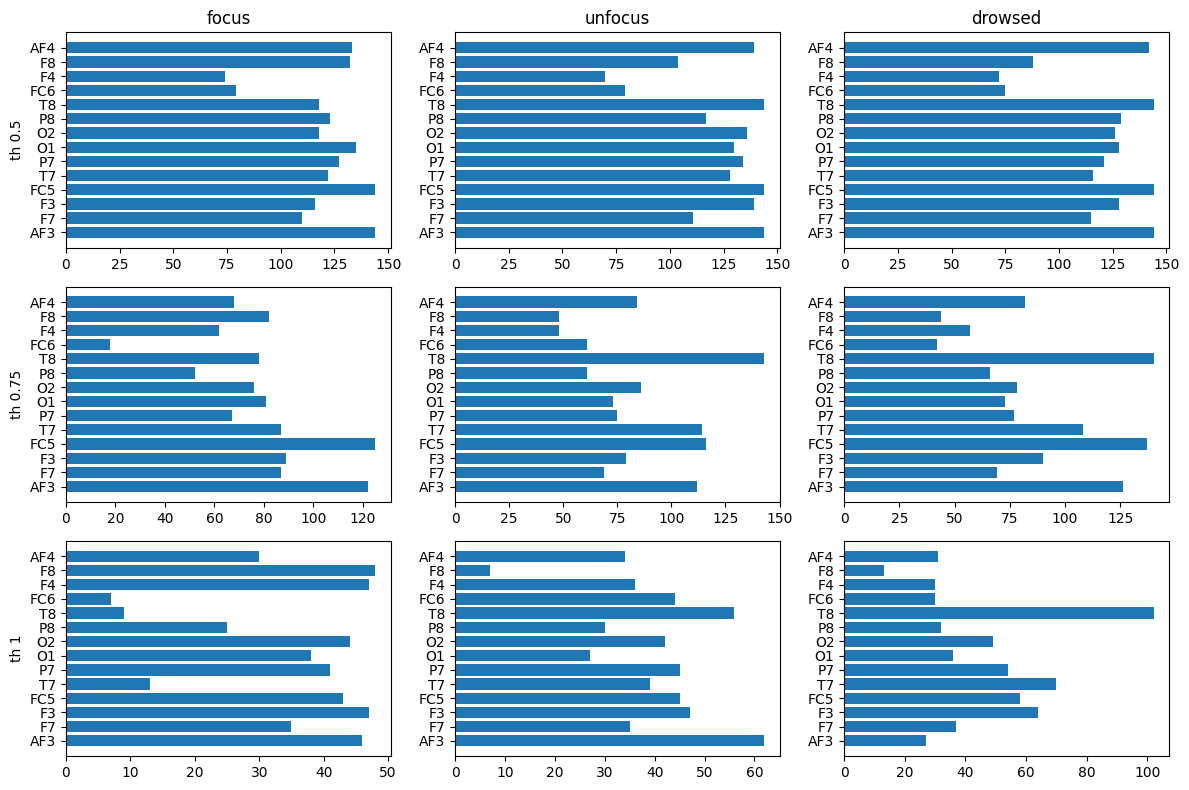

In [212]:
# Create the figure and axes
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

# Iterate through the subplots
labels = [subject0.focus_label, subject0.unfocus_label, subject0.drowsed_label]
thresholds = [.5, .75, 1]
for j, label_inst in enumerate(labels):
    axs[0, j].title.set_text(label_inst.label)
    for i, th in enumerate(thresholds):
        activities = check_ch_activation(subjects[0], label_inst.label, 'std', th)
        count_active_channels = dict(zip(channels, np.zeros(len(channels))))

        for active_channels, value in activities.items():
            if active_channels == '':
                continue
            active_channels = active_channels.split('-')
            for ch in active_channels:
                count_active_channels[ch] += value


        keys = list(count_active_channels.keys())
        values = list(count_active_channels.values())
        ax = axs[i, j]
        im = ax.barh(keys, values)

        axs[i, 0].set_ylabel(f'th {th}')


# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [247]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

for sample_length in [20, 10, 5, 3, 1]:
    subjects = [Subject(i, slice_from, slice_to, sample_length=sample_length) for i in range(5)]
    concatenated_dfs = []
    for subject in subjects:
        df1 = create_ch_feature(subject, 'focus', 'std')
        df1['label'] = 'focus'
        df2 = create_ch_feature(subject, 'unfocus', 'std')
        df2['label'] = 'unfocus'
        df3 = create_ch_feature(subject, 'drowsed', 'std')
        df3['label'] = 'drowsed'
        concatenated_dfs.append(pd.concat([df1, df2, df3], ignore_index=True))

    concatenated_df = pd.concat(concatenated_dfs, ignore_index=True)
    X = concatenated_df[channels]
    y = concatenated_df['label']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    dt_classifier = RandomForestClassifier()
    dt_classifier.fit(X_train, y_train)

    predictions = dt_classifier.predict(X_val)
    acc = np.sum(predictions == y_val)/len(y_val)
    print(f'For sample length of {sample_length}s the accuracy is {acc*100:.2f}')

For sample length of 20s the accuracy is 83.33
For sample length of 10s the accuracy is 86.57
For sample length of 5s the accuracy is 88.77
For sample length of 3s the accuracy is 87.50
For sample length of 1s the accuracy is 84.56


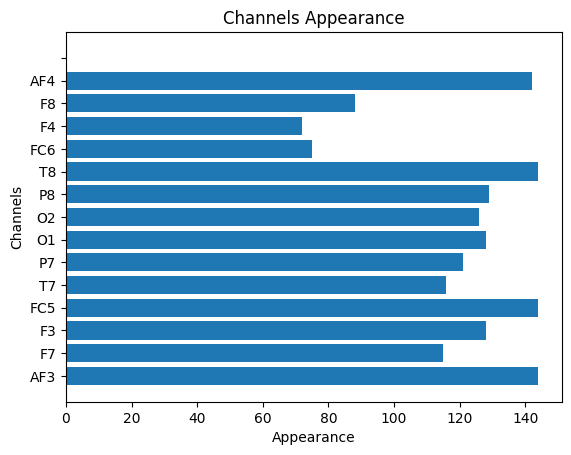

In [206]:
activities = check_ch_activation(subjects[0], 'drowsed', 'std', .5)
count_active_channels = dict(zip(channels, np.zeros(len(channels))))
count_active_channels[''] = 0

for active_channels, value in activities.items():
    active_channels = active_channels.split('-')
    for ch in active_channels:
        count_active_channels[ch] += value


keys = list(count_active_channels.keys())
values = list(count_active_channels.values())
plt.barh(keys, values)

plt.xlabel('Appearance')
plt.ylabel('Channels')
plt.title('Channels Appearance')

# Display the plot
plt.show()

# Topography Map

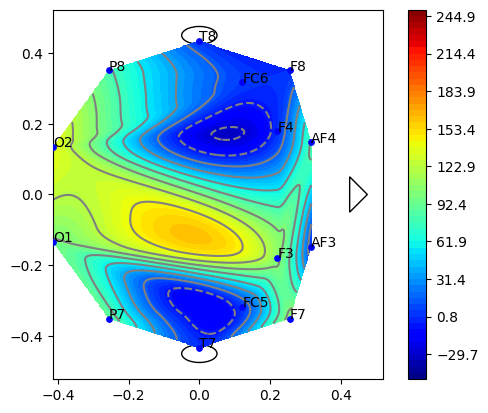

In [11]:
dat = get_trial_data(2)
fig, _ = topography_map(dat.iloc[1300 * 128: 1325 * 128], vmin=-50, vmax=250)

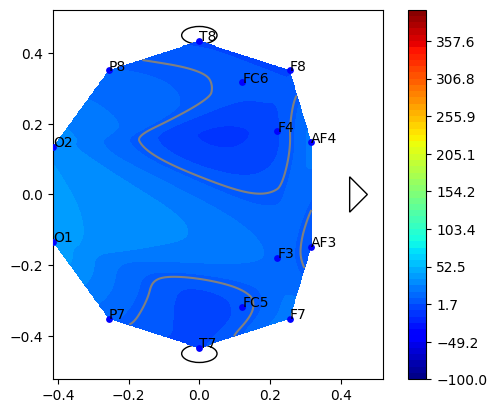

In [6]:
fig, _ = topography_map(dat.iloc[(600+120) * 128: (600+121) * 128], vmin=-100, vmax=400)

In [28]:
dat.iloc[slice_from * 128: slice_to * 128].to_csv('trial2_s120_focus.csv')
dat.iloc[(600 + slice_from) * 128: (600 + slice_to) * 128].to_csv('trial2_s720_unfocus.csv')
dat.iloc[(1200 + slice_from) * 128: (1200 + slice_to) * 128].to_csv('trial2_s1320_drowsed.csv')

In [7]:
from tqdm.notebook import tqdm
import matplotlib.animation as animation
from PIL import Image
import imageio


def topographic_gif(trial, label):
    sprite_dir = '.sprite'
    dat = get_trial_data(trial)

    seconds = {
        'focus': range(2 * 60, 3 * 60),
        'unfocus': range(12 * 60, 13 * 60),
        'drowsed': range(22 * 60, 23 * 60),
    }[label]
    vmin=-100
    vmax=400
    for second in tqdm(seconds):
        fig, _ = topography_map(dat.iloc[second * 128: (second + 1) * 128], vmin=vmin, vmax=vmax)
        plt.savefig(f"{sprite_dir}/{second}.png", dpi=80)
        plt.close(fig)


    image_files = sorted([f for f in os.listdir(sprite_dir) if f.endswith('.png')],
                         key=lambda x: int(os.path.splitext(x)[0]))
    frames = []
    for image_file in image_files:
        image_path = os.path.join(sprite_dir, image_file)
        image = Image.open(image_path)
        frames.append(image)

    for i in range(20):
        frames.append(np.zeros_like(image))
    output_path = f'.gifs/{trial}_{label}.gif'
    imageio.mimwrite(output_path, frames, fps=10)
    # frames[0].save(output_path, format='GIF', append_images=frames[1:], save_all=True, duration=200, loop=True)

    for image, image_file in zip(frames[:-20], image_files):
        image.close()
        image_path = os.path.join(sprite_dir, image_file)
        os.remove(image_path)

In [8]:
for trial in range(3, 7):
    topographic_gif(trial, 'focus')
    topographic_gif(trial, 'unfocus')
    topographic_gif(trial, 'drowsed')

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]